# 0050.TW Improved Trading Signal Design

This project is made for trying to use the volume of 0050 to produce signal that can invest in relative low point of it.

## Get the data

In [1]:
# Get the 0050.TW stock data

# Import the related library to backtest and see the pattern of 0050.TW

import yfinance as yf
import pandas as pd

ticker = "0050.TW"
data = yf.download(ticker, start="2017-01-01", end="2023-07-16")

print(data.head())

# Save the data to CSV
data.to_csv('0050_stock_data.csv')

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2017-01-03  71.699997  71.900002  71.500000  71.900002  55.905369  2331431
2017-01-04  72.000000  72.099998  71.750000  71.849998  55.866493  4284195
2017-01-05  71.849998  72.500000  71.800003  72.500000  56.371899  4573600
2017-01-06  72.449997  72.750000  72.449997  72.650002  56.488525  3752998
2017-01-09  72.750000  72.949997  72.300003  72.449997  56.333004  5038290


## Plot the chart of 0050.TW

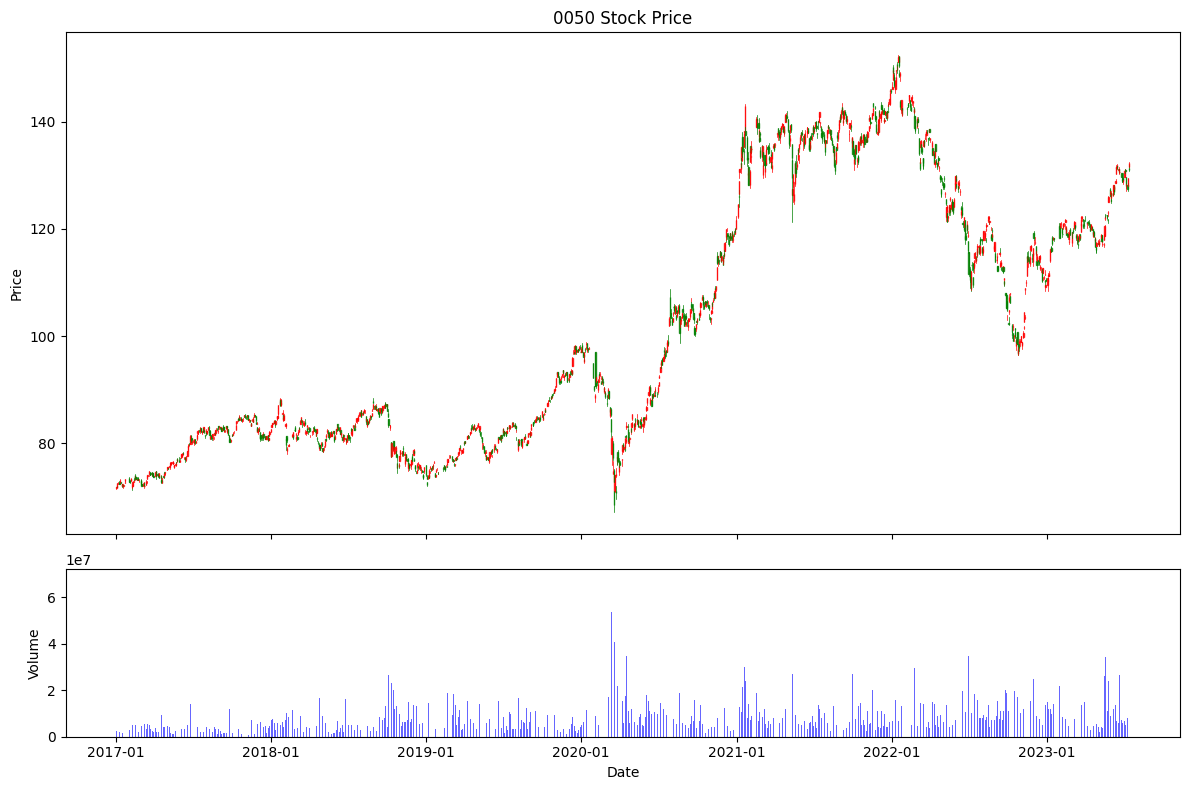

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc

# Reset the index of the data
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].apply(mdates.date2num)

# Set the figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Draw the chart of classic stock price and volume in Taiwanese style which means that red is raising price
ohlc = data[['Date', 'Open', 'High', 'Low', 'Close']]
candlestick_ohlc(ax1, ohlc.values, width=0.6, colorup='r', colordown='g', alpha=0.8)

ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.set_title('0050 Stock Price')
ax1.set_ylabel('Price')

ax2.bar(data['Date'], data['Volume'], width=0.6, color='b', alpha=0.6)
ax2.set_ylabel('Volume')

# Show the plot
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Save the plot
fig.savefig('0050_stock_chart.png')


## Design the signal and implement

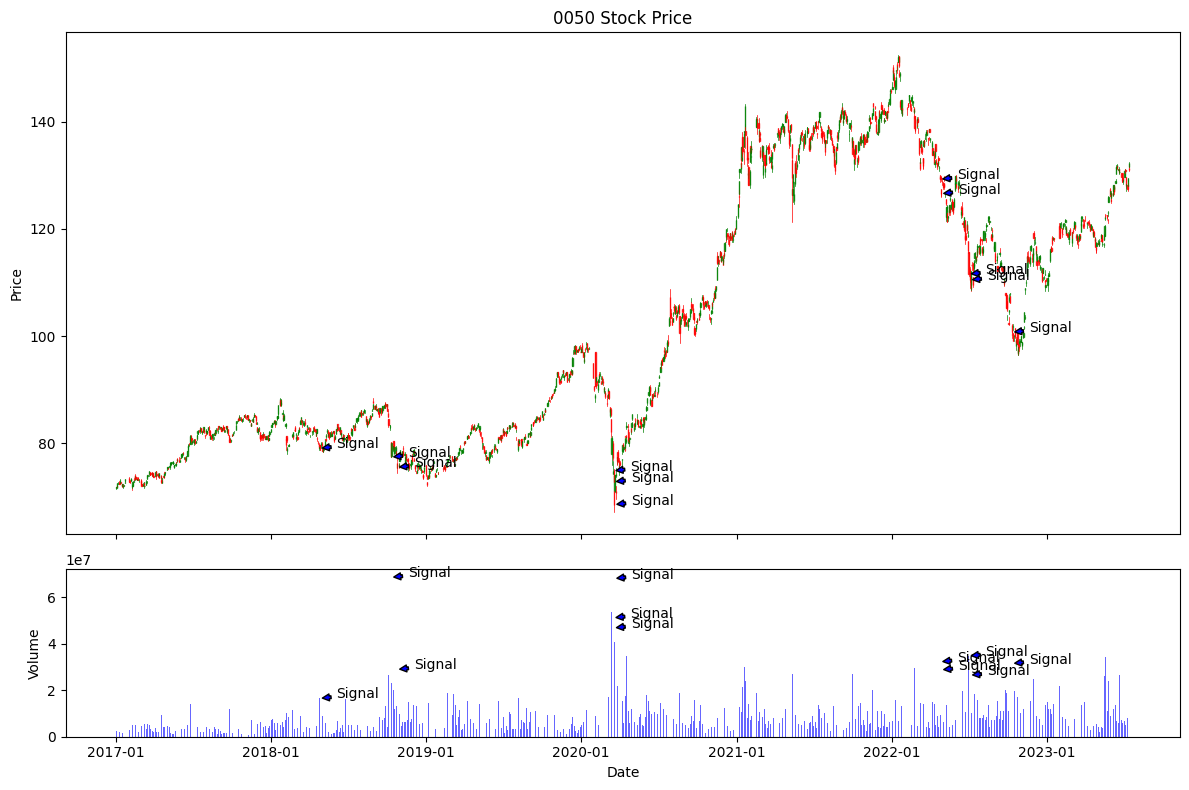

,股價,成交量,平均成交量,成交量標準差
日期,,,,
2018-04-26,79.050003,16485778.0,4.365941e+06,3.594074e+06
2018-10-11,77.400002,68551624.0,6.720698e+06,7.192798e+06
2018-10-25,75.500000,28935886.0,7.615210e+06,8.165796e+06
2020-03-17,74.849998,51145832.0,8.500061e+06,7.974738e+06
2020-03-18,72.800003,46790503.0,8.634940e+06,8.384655e+06
2020-03-19,68.550003,68038340.0,8.922341e+06,9.377277e+06
2022-04-25,129.250000,32212970.0,1.053320e+07,7.562419e+06
2022-04-27,126.550003,28746564.0,1.065397e+07,7.659051e+06
2022-07-01,111.550003,34719560.0,1.065908e+07,7.640956e+06


In [3]:
# Define the main function to signify the relative low point of stock price and abnormal increasing volume
# with rolling window of 200 days and 2 times std 
def identify_major_lows(data, window=200, volume_threshold=2):
    data['Rolling_Low'] = data['Close'].rolling(window=window).min()
    data['Rolling_Volume_mean'] = data['Volume'].rolling(window=window).mean()
    data['Rolling_Volume_std'] = data['Volume'].rolling(window=window).std()
    lows_with_volume_spike = data[(data['Close'] == data['Rolling_Low']) & (data['Volume'] > data['Rolling_Volume_mean'] + data['Rolling_Volume_std']*volume_threshold)]
    return lows_with_volume_spike[['Date', 'Close', 'Volume', 'Rolling_Volume_mean', 'Rolling_Volume_std']]

# Find out the relative low point of stock price and abnormal increasing volume of 0050.TW
lows_with_volume_spike = identify_major_lows(data)

# Build up the info dict of the abnormal point
info_abnormal_data = {
    "日期": [mdates.num2date(row['Date']).strftime('%Y-%m-%d') for idx, row in lows_with_volume_spike.iterrows()],
    "股價": [row['Close'] for idx, row in lows_with_volume_spike.iterrows()],
    "成交量": [row['Volume'] for idx, row in lows_with_volume_spike.iterrows()],
    "平均成交量": [row['Rolling_Volume_mean'] for idx, row in lows_with_volume_spike.iterrows()],
    "成交量標準差": [row['Rolling_Volume_std'] for idx, row in lows_with_volume_spike.iterrows()]
}

# Build up new DataFrame
df = pd.DataFrame(info_abnormal_data)

# Set date to the index
df.set_index("日期", inplace=True)

# Set up the figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Draw the graph
ohlc = data[['Date', 'Open', 'High', 'Low', 'Close']]
candlestick_ohlc(ax1, ohlc.values, width=0.6, colorup='g', colordown='r', alpha=0.8)

# Point out the relative low point of stock price and abnormal increasing volume of 0050.TW
for idx, row in lows_with_volume_spike.iterrows():
    ax1.annotate('Signal', xy=(row['Date'], row['Close']), xytext=(row['Date']+40, row['Close']*1),
                 arrowprops=dict(arrowstyle='simple',facecolor='blue'))
    ax2.annotate('Signal', xy=(row['Date'], row['Volume']), xytext=(row['Date']+40, row['Volume']*1),
                 arrowprops=dict(arrowstyle='simple', facecolor='blue'))

ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.set_title('0050 Stock Price')
ax1.set_ylabel('Price')

ax2.bar(data['Date'], data['Volume'], width=0.6, color='b', alpha=0.6)
ax2.set_ylabel('Volume')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Show the date of abnormal point
df


## Conclusion and Suggestion

Through this project, we can find that when the stock price is at a low of nearly 200 days and the trading volume is abnormally large, it is often a good buying point for 0050. In the future, this project can further design sell signals to form a complete trading strategy.